### Improving RNNs with GRU and LSTM

As we know, standard RNNs have multiple problems including the vanishing/exploding gradient problem. By construction, RNNs can be easily adjusted with custom cells between the time steps, similar to custom layers in standard Neural Networks. Two standard adaptations of standard RNNs to solve some of its problems are the `Gated Recurrent Unit` and the `Long-Short-Term-Memory` which have had a lasting impact on Machine Learning Research to date. We want to see, how we can implement these two variants in PyTorch, similar to how we implement the `BasicRNN`.


##### Long-Short-Term-Memory (LSTM) 

For an overview, see https://en.wikipedia.org/wiki/Long_short-term_memory and the original paper https://www.researchgate.net/publication/13853244_Long_Short-Term_Memory.

- idea is to, via an additional LSTM-cell, enforce that the network learns that some things are not worth remembering 
- somewhat solve Vanishing Gradient Problem, exploding gradients still not solved

The above things it enforces via the below LSTM-cell (taken from wikipedia), where $h_t$ is our classical hidden state, $c_t$ is the memory/cell state at time and $x_t$ is our input at time $t$. A key difference is that $h_t$ also is the output of our model at time $t$ as opposed to having a explicit output. 


<div style="width: 50%; margin: 0 auto">
  <img src="LSTM_Cell.svg.png" style="width: 100%; height: auto; border: 1px solid #ddd">
</div>


Let's look at an example, in the following, we are going to implement a basic LSTM Network combined with a standard linear layer to see how we can also use Recurrent Networks for images, this, often, is not as good as Convolutional Networks, but i think it is still nice to see that we can also solve image classification tasks using a Recurrent Network.

To make training a bit faster, we are not going to implement it the same way we did the `RNN` but instead use batching, which makes the code (imo) not as redeable, but way faster.

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision # for dataset of MNIST images
from torchvision import transforms
from torchviz import make_dot

In [2]:
#constants we need

input_dim = 28 # we take every image as a sequence of 28 row vectors.
hidden_dim = 128
classes_amount = 10 # 10 digits

class basicLSTM(nn.Module):
    def __init__(self, input_dim, hidde_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        
        # Parameters we want to train, i = input, h = hidden, f = forget gate, o = output, g = cell candidate to update cell
        # because we have so many variables in our class, we are just going to stick to the classic activations and not have them as custom ones
        self.W_ii = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hi = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_i = nn.Parameter(torch.Tensor(hidden_dim))
        
        self.W_if = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hf = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_f = nn.Parameter(torch.Tensor(hidden_dim))
        
        self.W_ig = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hg = nn.Parameter(torch.Tensor(hidden_dim,hidden_dim))
        self.b_g = nn.Parameter(torch.Tensor(hidden_dim))
        
        self.W_io = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_ho = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_o = nn.Parameter(torch.Tensor(hidden_dim))
        
        self.first_grads = []
        self.middle_grads = []
        self.end_grads = []
    #h_t = None, c_t = None
    def forward(self, x):
        #shape of x is supposed to be (batch, seq_length, input_dim)
        batch, seq_length, _ = x.size()
        
        h_t = torch.zeros(batch, self.hidden_dim) 
        c_t = torch.zeros(batch, self.hidden_dim)
    
        #now, similar to the RNN implementation, we are going to go through the cell sequentially
        
        for t in range(seq_length):
            x_t = x[:, t, :] # extract t-th timestep 
            
            #input gate, since x_t, y_t etc. are row vectors (per batch) we multiply them from the left
            i_t = torch.sigmoid( x_t @ self.W_ii +  h_t @ self.W_hi+  self.b_i) # using torch.sigmoid instea of the nn.Sigmoid class since we do not have it as a variable anyway
            #forget gate
            f_t = torch.sigmoid(x_t @ self.W_if + h_t @ self.W_hf + self.b_f)
            #cell candidate for update
            g_t = torch.tanh(x_t @ self.W_ig + h_t @ self.W_hg + self.b_g)
            #output
            o_t = torch.sigmoid(x_t @ self.W_io +h_t @ self.W_ho + self.b_o)
            
            c_t = f_t * c_t + i_t * g_t #update cell
            
            # Update hidden state
            h_t = o_t * torch.tanh(c_t)
            
            if t == 0:
                h_t.register_hook(lambda grad: self.first_grads.append(grad.norm().item()))
            if t == seq_length//2:
                h_t.register_hook(lambda grad: self.middle_grads.append(grad.norm().item()))
            if t == seq_length-1:
                h_t.register_hook(lambda grad: self.end_grads.append(grad.norm().item()))
                
        return h_t
        
#above we had the basic LSTM, now, lets get the classification working
class MNISTLSMT(nn.Module):
    def __init__(self, input_dim, hidde_dim, classes_amount):
        super().__init__()
        
        self.lstm = basicLSTM(input_dim, hidde_dim)
        self.lstm_out = nn.Linear(hidde_dim, classes_amount)
        self.act_out = nn.Sigmoid()
    def forward(self, x):
        x = x.reshape(-1,28,28)
        out = self.lstm(x)
        return self.act_out(self.lstm_out(out))
        

In [3]:
epochs = 5
batch_size = 100
learning_rate = 0.01

train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor(),
    download=True
)

#for the batching, we could also use Dataloader, but for now lets keep it step by step and implement out own "dataloader"
train_labels = train_dataset.targets
train_data = train_dataset.data
#normalize
train_data = train_data.type(torch.float32)
train_data = (train_data-torch.mean(train_data))/torch.std(train_data)

#batching
train_labels = train_labels.reshape(60000//batch_size, batch_size)
train_data = train_data.reshape(60000//batch_size, batch_size, 28,28)

model = MNISTLSMT(input_dim, hidden_dim, classes_amount)
lossfunction = nn.CrossEntropyLoss() #classification loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for i in range(train_data.size()[0]):
        images = train_data[i]
        labels = train_labels[i]
            
        # Forward pass
        outputs = model(images)
        loss = lossfunction(outputs, labels)
        
        _, predicted = torch.max(outputs, 1)  
        total_correct = (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0: 
            print(f"The loss for Batch {i} in epoch {epoch} is {loss}")
            print(f"Accuracy for Batch {i} in epoch {epoch} is {total_correct/batch_size*100:.2f}%")

The loss for Batch 0 in epoch 0 is 2.3015003204345703
Accuracy for Batch 0 in epoch 0 is 8.00%
The loss for Batch 100 in epoch 0 is 2.175285577774048
Accuracy for Batch 100 in epoch 0 is 11.00%
The loss for Batch 200 in epoch 0 is 1.9988038539886475
Accuracy for Batch 200 in epoch 0 is 19.00%
The loss for Batch 300 in epoch 0 is 1.9552128314971924
Accuracy for Batch 300 in epoch 0 is 20.00%
The loss for Batch 400 in epoch 0 is 1.909975290298462
Accuracy for Batch 400 in epoch 0 is 26.00%
The loss for Batch 500 in epoch 0 is 1.7549585103988647
Accuracy for Batch 500 in epoch 0 is 41.00%
The loss for Batch 0 in epoch 1 is 1.7677158117294312
Accuracy for Batch 0 in epoch 1 is 47.00%
The loss for Batch 100 in epoch 1 is 1.6499193906784058
Accuracy for Batch 100 in epoch 1 is 63.00%
The loss for Batch 200 in epoch 1 is 1.667812466621399
Accuracy for Batch 200 in epoch 1 is 67.00%
The loss for Batch 300 in epoch 1 is 1.5770392417907715
Accuracy for Batch 300 in epoch 1 is 84.00%
The loss for

In [4]:
#Lets test our Model
test_data = test_dataset.data
test_data = test_data.type(torch.float32).unsqueeze(-1)
test_data = (test_data-torch.mean(test_data))/torch.std(test_data)
test_labels = test_dataset.targets

out = model(test_data)

loss = lossfunction(out,test_labels)
_, predicted = torch.max(out, 1)  
total_correct = (predicted == test_labels).sum().item()


print(f"We got a loss of {loss.item()} on our test set")
print(f"The accuracy on our test set is {total_correct /len(test_data) * 100:.2f}%")

We got a loss of 1.5142749547958374 on our test set
The accuracy on our test set is 94.00%


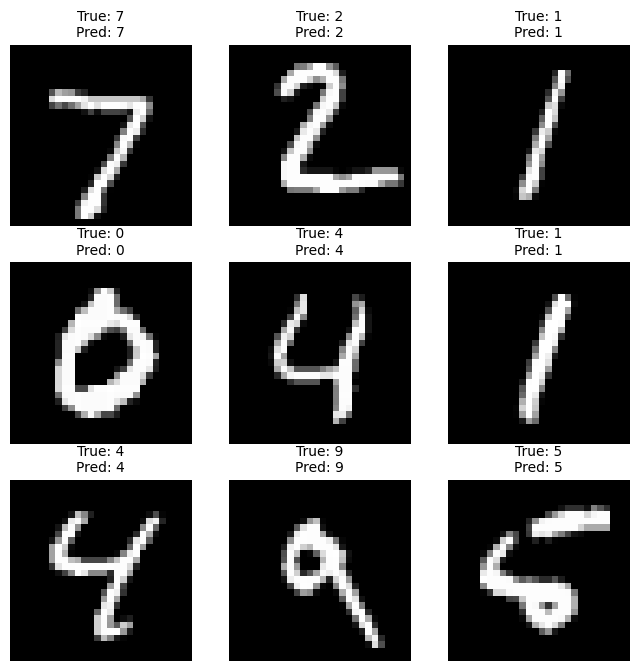

In [5]:
#lets see a specific example
fig, ax = plt.subplots(3,3, figsize=(8, 8))
for i in range(9):
    img = test_data[i]
    label = test_labels[i]
    out = model(img.unsqueeze(-1))
    ax[i // 3,i%3].imshow(img, cmap='gray')
    ax[i // 3, i % 3].set_title(f"True: {label}\nPred: {out.argmax()}", fontsize=10)
    ax[i //3 ,i%3].axis('off')  

## On the Vanishing Gradients
As we can see in the below plot, the gradients at our hidden states are relatively stable, although the exploding gradient problem can happen to LSTMs, it is not as drastic. We have somewhat validated the theory :)

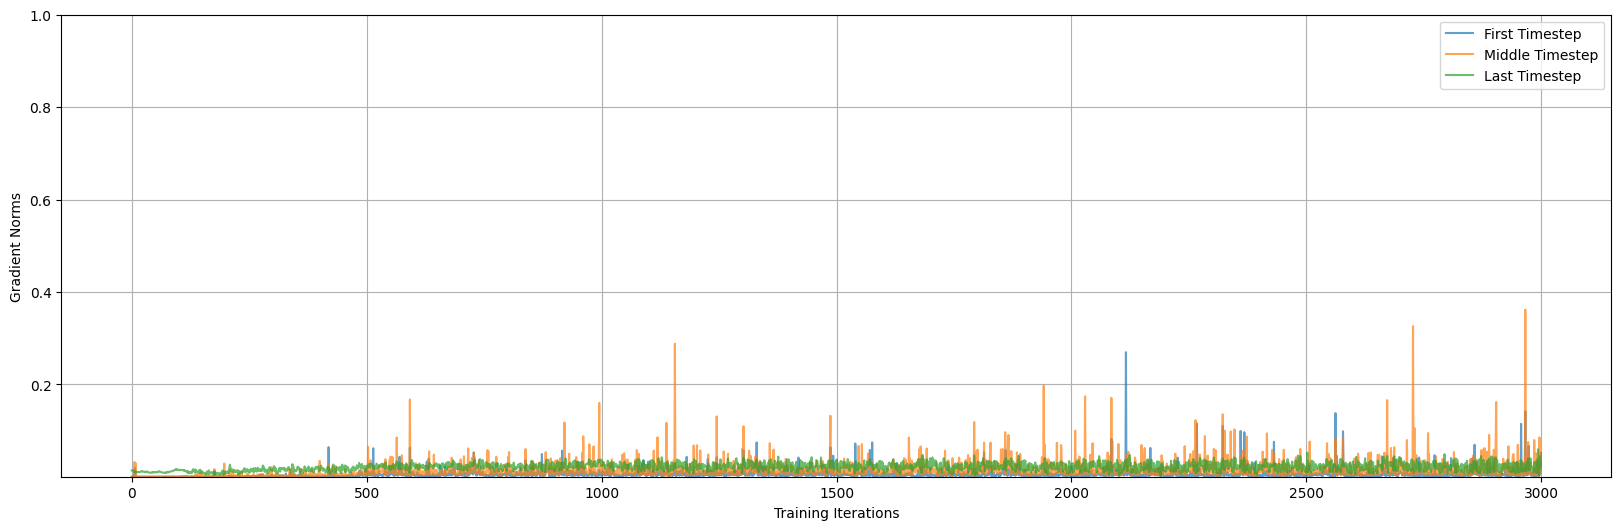

In [7]:
plt.figure(figsize=(20, 6))
plt.plot(model.lstm.first_grads, label="First Timestep", alpha=0.7)
plt.plot(model.lstm.middle_grads, label="Middle Timestep", alpha=0.7)
plt.plot(model.lstm.end_grads, label=f"Last Timestep ", alpha=0.7)
plt.xlabel("Training Iterations")
plt.ylabel("Gradient Norms")
plt.legend()
plt.ylim(1e-8, 1)  # clipping, for better visualisation
plt.grid(True)
plt.show()